In [1]:
import glob
import os
import pprint 
# import pyyaml

import astropy.units as u
from IPython.display import display
import matplotlib as mp
import matplotlib.pylab as pl
import pandas as pd

import astropy.constants as constants

from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import astropy.units as u
from astropy.table import Table, vstack

from pystrometry.pystrometry import pjGet_a_barycentre
from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase


In [2]:
LOCAL_PATH = os.path.dirname(os.getcwd())
TEMPORARY_DIR = os.path.join(LOCAL_PATH, 'temp')
if os.path.isdir(TEMPORARY_DIR) is False:
    os.makedirs(TEMPORARY_DIR)
print(LOCAL_PATH)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry


In [3]:
pp = pprint.PrettyPrinter(indent=4)     
%matplotlib inline
mp.rcParams['figure.figsize'] = (18, 9)
mp.rcParams['font.size'] = 20
mp.rcParams['ytick.direction'] = 'in'
mp.rcParams['xtick.direction'] = 'in'

In [4]:
save_plot = True

https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

In [5]:
# selected_table_name = 'eod'  # ExoplanetOrbitDatabase
selected_table_name = 'nasa'  # NasaExoplanetArchive

def get_exoplanets(selected_table_name, overwrite=False):
    
    local_data_file_name = {'eod': 'exoplanet_orbit_database_table.ecsv',
                           'nasa': 'nasa_exoplanet_archive_table.ecsv'}

    eod_file = os.path.join(TEMPORARY_DIR, local_data_file_name[selected_table_name])

    if not os.path.isfile(eod_file) or overwrite:
        if selected_table_name == 'eod':
            table = ExoplanetOrbitDatabase.get_table()
        elif selected_table_name == 'nasa':
            # https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html
            table = NasaExoplanetArchive.query_criteria(table="exoplanets", select="*", cache=True)
            #         table = NasaExoplanetArchive.query_criteria(table="cumulative", select="*", cache=True)
            #         table_kepler = NasaExoplanetArchive.query_criteria(table="cumulative", select="*", cache=True)

        table.write(eod_file, overwrite=True)

    table = Table.read(eod_file)
    return table

In [6]:
table = get_exoplanets(selected_table_name)

In [7]:
parameter_mapping_all = {'eod': {'period': 'PER',
                     'ecc': 'ECC',
                     'm2': 'MASS',
                     'omega': 'OM',
                     'plx': 'PAR',
                     'star_mass': 'MSTAR',
                     'distance_pc': 'DIST'
                     },
                     'nasa':{'period': 'pl_orbper',         # https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
                             'm2': 'pl_bmassj',
                             'plx': 'gaia_plx',
                             'star_mass': 'st_mass',
                             'distance_pc': 'st_dist'
                             }}


def set_astrometric_observables(table, selected_table_name):
    """Compute photocentre orbit size and other parameters."""

    parameter_mapping = parameter_mapping_all[selected_table_name]                     

    planet_mass_mj = table[parameter_mapping['m2']]
    parallax_mas = table[parameter_mapping['plx']]
    period_day = table[parameter_mapping['period']]
    star_mass_msun = table[parameter_mapping['star_mass']]

    table['a_phot_mas'] = pjGet_a_barycentre(star_mass_msun, planet_mass_mj, period_day, parallax_mas)
    table['period_year'] = (table[parameter_mapping['period']].to(u.year))
    table['a_phot_muas'] = table['a_phot_mas']*1000

    table['log10_distance_pc'] = np.log10(table[parameter_mapping['distance_pc']])
    
    return table

In [8]:
table = set_astrometric_observables(table, selected_table_name)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/pystrometry/pystrometry.py:3740: RuntimeWarning: invalid value encountered in true_divide
  / (m1_MS * MS_kg + m2_MJ * MJ_kg)**2.) # mass term for the barycentric orbit of the primary mass
/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/pystrometry/pystrometry.py:3742: RuntimeWarning: divide by zero encountered in true_divide
  d_pc  = 1. / (plx_mas / 1000.)
/Users/jsahlmann/opt/anaconda3/envs/astrom/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


In [9]:
eod_table = get_exoplanets('eod')  # ExoplanetOrbitDatabase
eod_table = set_astrometric_observables(eod_table, 'eod')

/Users/jsahlmann/opt/anaconda3/envs/astrom/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


### Complement NasaExoplanetArchive with KOIs from ExoplanetOrbitDatabase

In [10]:
eod_df = eod_table.to_pandas()
eod_df_koi = eod_df[eod_df['EANAME'].str.contains('Kepler').fillna(False)]
# eod_df_koi.info()

## Solar system planets  at 10 pc     
http://www.windows2universe.org/our_solar_system/planets_table.html

In [11]:


solar_system = pd.DataFrame()

solar_system['period_year'] = [0.24 ,0.62, 1, 1.88, 11.86, 29.46, 84.01, 164.8]
solar_system['period_day'] = solar_system['period_year'] * u.year.to(u.day)
solar_system['planet_mass_mj'] = np.array([0.055,0.815, 1, 0.107, 318, 95, 15, 17]) * u.M_earth.to(u.M_jup)
solar_system['distance_pc'] = 10
solar_system['parallax_mas'] = 1e3/solar_system['distance_pc']
solar_system['planet_name'] = ['Me','V','E','Ma','J','S','U','N']
solar_system['star_mass_msun'] = 1

solar_system['a_phot_mas'] = pjGet_a_barycentre(solar_system['star_mass_msun'], solar_system['planet_mass_mj'], solar_system['period_day'], solar_system['parallax_mas'])
solar_system['a_phot_muas'] = solar_system['a_phot_mas']*1e3
# sols_m2_MJ = [0.055,0.815, 	1, 	0.107, 	318, 	95, 	15, 	17]*ME/MJ;
# sols_P_day = [0.24 ,0.62, 	1, 	1.88, 	11.86, 	29.46, 	84.01, 	164.8]*year2day;
# sols_name={};
# sols_d_pc = ones(1,numel(sols_m2_MJ))*10;
# sols_m1_MS = ones(1,numel(sols_m2_MJ));

solar_system

,period_year,period_day,planet_mass_mj,distance_pc,parallax_mas,planet_name,star_mass_msun,a_phot_mas,a_phot_muas
0,0.24,87.6600,0.000173,10,100.0,Me,1,0.000006,0.006380
1,0.62,226.4550,0.002564,10,100.0,V,1,0.000178,0.177980
2,1.00,365.2500,0.003146,10,100.0,E,1,0.000300,0.300345
3,1.88,686.6700,0.000337,10,100.0,Ma,1,0.000049,0.048953
4,11.86,4331.8650,1.000540,10,100.0,J,1,0.496395,496.395467
5,29.46,10760.2650,0.298903,10,100.0,S,1,0.272114,272.113525
6,84.01,30684.6525,0.047195,10,100.0,U,1,0.086414,86.414409
7,164.80,60193.2000,0.053488,10,100.0,N,1,0.153471,153.470970


## Individual systems (mostly Gaia-HIP accelerations)

In [12]:
# TODO: add beta pic

# add ups And, GJ676Ab?, VLBI planet, Guillem escude planet Feng+19, 


individuals = pd.DataFrame()

individuals['planet_name'] = ['HD 33632 Ab', 'Proxima c', 'HD 113337 c', 'HD 38529 c', 'pi Men b', 'beta Pic b', 'eps indi A b']
individuals['ref'] = ['Currie+20', 'Kervella+20', 'Xuan+20', 'Xuan+20', 'De Rosa+20', 'Brandt+20', 'Feng+19']

individuals['period_year'] = np.array([91* u.year.to(u.day), 1900, 3165, 2135, 2089.11, 8880, 45.2*u.year.to(u.day)])* u.day.to(u.year)
individuals['period_day'] = individuals['period_year'] * u.year.to(u.day)
individuals['planet_mass_mj'] = np.array([46, 12* u.M_earth.to(u.M_jup), 14, 18, 13.01, 9.8, 3.25]) 
individuals['distance_pc'] = [26.56, 1000./768.5, 1000./27.64, 1000./23.611, 1000/ 54.7052, 1000./50.58, 1000./274.8]
individuals['parallax_mas'] = 1e3/individuals['distance_pc']
individuals['star_mass_msun'] = [1.108, 0.122, 1.40, 1.36, 1.094, 1.83, 0.754]


individuals['a_phot_mas'] = pjGet_a_barycentre(individuals['star_mass_msun'], individuals['planet_mass_mj'], individuals['period_day'], individuals['parallax_mas'])
individuals['a_phot_muas'] = individuals['a_phot_mas']*1e3

individuals

,planet_name,ref,period_year,period_day,planet_mass_mj,distance_pc,parallax_mas,star_mass_msun,a_phot_mas,a_phot_muas
0,HD 33632 Ab,Currie+20,91.000000,33237.75,46.000000,26.560000,37.650602,1.108,30.438599,30438.599047
1,Proxima c,Kervella+20,5.201916,1900.00,0.037756,1.301236,768.500000,0.122,0.337984,337.983829
2,HD 113337 c,Xuan+20,8.665298,3165.00,14.000000,36.179450,27.640000,1.400,1.237368,1237.368314
3,HD 38529 c,Xuan+20,5.845311,2135.00,18.000000,42.353140,23.611000,1.360,1.063517,1063.516641
4,pi Men b,De Rosa+20,5.719671,2089.11,13.010000,18.279798,54.705200,1.094,2.031204,2031.203704
5,beta Pic b,Brandt+20,24.312115,8880.00,9.800000,19.770660,50.580000,1.830,2.645187,2645.186869
6,eps indi A b,Feng+19,45.200000,16509.30,3.250000,3.639010,274.800000,0.754,13.022748,13022.747616


In [13]:
print(individuals[['planet_name', 'ref']].to_csv(index=False, sep=';'))

planet_name;ref
HD 33632 Ab;Currie+20
Proxima c;Kervella+20
HD 113337 c;Xuan+20
HD 38529 c;Xuan+20
pi Men b;De Rosa+20
beta Pic b;Brandt+20
eps indi A b;Feng+19



In [14]:
# pl.legend?

## Make overview plot 

'/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry/temp/nasa_True_astrometry_signatures.png'

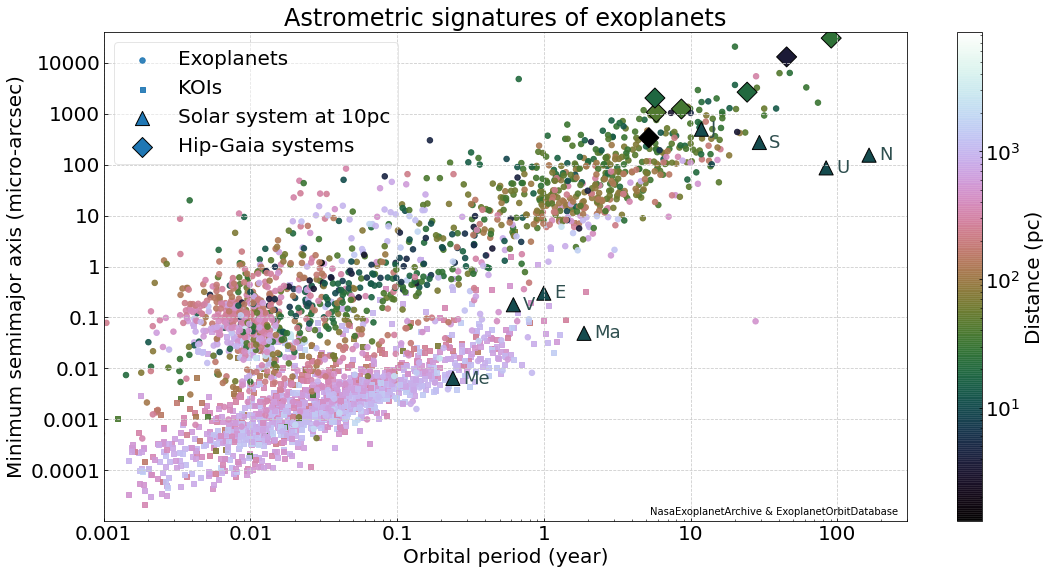

In [15]:
include_koi = True
include_individuals = True


df = table.to_pandas()

factor = 1000

def annotate_df(row):  
    #     https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting-from-pandas-dataframe
    ax.annotate(row.planet_name, (row.period_year, row.a_phot_muas),
                xytext=(10,-5), 
                textcoords='offset points',
                size=18, 
                color='darkslategrey')
    

x = 'period_year' 
y = 'a_phot_muas'

colour_by = 'distance_pc'
norm = mp.colors.LogNorm()
colormap='viridis'
colormap='cubehelix'



fig, ax = pl.subplots()
df.plot('period_year', 'a_phot_muas', kind='scatter', logx=True, logy=True, c=parameter_mapping_all['nasa'][colour_by], colormap=colormap, s=30, alpha=0.9, norm=norm, ax=ax, zorder=1, label='Exoplanets')
if include_koi:
    eod_df_koi.plot('period_year', 'a_phot_muas', kind='scatter', logx=True, logy=True, c=parameter_mapping_all['eod'][colour_by], colormap=colormap, s=25, marker='s', alpha=0.9, zorder=-50, norm=norm, ax=ax, colorbar=False, label='KOIs')
pl.ylim((1e-8*factor, 40*factor))
pl.xlim((1e-3, 300))
solar_system.plot('period_year', 'a_phot_muas', kind='scatter', logx=True, logy=True, s=200, c=colour_by, ax=ax, norm=norm, colormap=colormap, colorbar=False, marker='^', label='Solar system at 10pc', edgecolor='k')
_ = solar_system.apply(annotate_df, axis=1)
if include_individuals:
    individuals.plot('period_year', 'a_phot_muas', kind='scatter', logx=True, logy=True, s=200, c=colour_by, ax=ax, norm=norm, colormap=colormap, colorbar=False, label='Hip-Gaia systems',  marker='D', edgecolor='k') #,
# for i, name in enumerate(solar_system.name):
#     pl.()
pl.xlabel('Orbital period (year)')
pl.ylabel('Minimum semimajor axis (micro-arcsec)')
ax.grid(ls='--', color='0.8')
ax.set_zorder(-52)

xticks = [0.001, 0.01, 0.1, 1, 10, 100] 
xtick_labels = np.array(['0.001', '0.01', '0.1', '1', '10', '100'])
pl.xticks(xticks, xtick_labels)

yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 1e4] 
ytick_labels = np.array(yticks).astype(str)
ytick_labels = np.array(['0.0001', '0.001', '0.01', '0.1', '1', '10', '100', '1000', '10000'])
pl.yticks(yticks, ytick_labels)

cax = fig.get_axes()[1]
cax.set_ylabel('Distance (pc)')
pl.legend(loc=2, framealpha=0.5)
# if selected_table_name == 'eod':
#     pl.title('{} planets from exoplanets.org (last updated June 2018)'.format(df[y].count()))
# if selected_table_name == 'nasa':
#     pl.title('{} confirmed planets from exoplanetarchive.ipac'.format(df[y].count()))
# ax.xaxis.set_major_formatter(mp.ticker.ScalarFormatter())
# ax.yaxis.set_major_formatter(mp.ticker.ScalarFormatter())
# ax.ticklabel_format(useOffset=False, style='plain')

pl.text(0.68, 0.03, 'NasaExoplanetArchive & ExoplanetOrbitDatabase', horizontalalignment='left', verticalalignment='top',
        transform=pl.gca().transAxes, fontsize=10)

pl.title('Astrometric signatures of exoplanets')
if save_plot:
    figure_file_name = os.path.join(TEMPORARY_DIR, '{}_{}_astrometry_signatures.png'.format(selected_table_name, include_individuals))
    pl.savefig(figure_file_name, transparent=False, bbox_inches='tight', pad_inches=0.05)        
figure_file_name    

In [16]:
# pl.plot?

In [17]:
1/0

ZeroDivisionError: division by zero

In [ ]:
table.colnames

In [ ]:
from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase

In [ ]:
NasaExoplanetArchive.query_criteria?

In [ ]:
import astroquery
astroquery.__version__